In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

In [6]:
def chao_wor(x, q):
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    f1 = (x == 1).sum() # number of singletons
    f2 = (x == 2).sum() # number of doubletons
    return t + (f1**2) / ((n / (n - 1)) * 2*f2 + (q / (1 - q)) * f1)


def chao1(x):
    x = x[x > 0]
    n = x.sum()
    t = len(x)
    f1 = (x == 1).sum()
    f2 = (x == 2).sum()
    if f2 > 0:
        return t + (n-1)/n * (f1**2 / (2*f2))
    return t + (n-1)/n * f1*(f1-1) / 2*(f2+1)

def ci_plot(x, y, n=20, percentile_min=1, percentile_max=99,
            color='C0', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    perc1 = np.percentile(
        y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(
        y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    alpha = 1/n
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)
        ax.plot(x, np.mean(y, axis=0), color=color, label=label)
    return ax

In [56]:
df = pd.read_csv('../data/raw/vocapture.tar.gz', compression='gzip')

df = df.dropna(subset='date_begin_contract')

In [57]:
df.groupby(['outward_voyage_id'])['person_cluster_id'].count().median()

171.0

Between 1700 and 1740, there were 1381 outward voyages. The median number of people on a ship was 171.
This shows that there were about 236,151 sailors.

In [60]:
df = df[(df['date_begin_contract'].str[:4].astype(int) > 1700) & (df['date_begin_contract'].str[:4].astype(int) < 1740)]

In [61]:
records = df.loc[df['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values

In [62]:
counts = np.array(list(collections.Counter(records).values()))
N, V = counts.sum(), counts.shape[0]

#N, V = len(records), len(np.unique(records))
print(f"The archive consists of N={N} records and V={V} unique sailors.")

The archive consists of N=190030 records and V=163349 unique sailors.


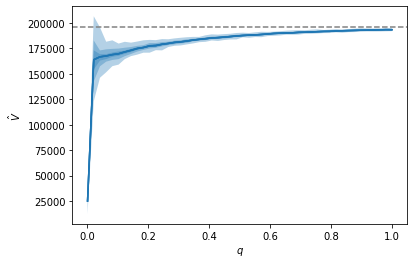

In [38]:
n_steps, n_experiments = 50, 100
fractions = np.linspace(0.001, 0.999, n_steps)
est_wr = np.zeros((n_experiments, n_steps))
for j, q in enumerate(fractions):
    for i in range(n_experiments):
        _, sample = np.unique(
            np.random.choice(V, size=int(q * N), p=counts/counts.sum()),
            return_counts=True)
        est_wr[i, j] = chao1(sample)

fig, ax = plt.subplots()
ci_plot(fractions, est_wr, n=3, color="C0", ax=ax)
ax.set(ylabel="$\hat{V}$", xlabel="$q$")
ax.axhline(V, color="grey", ls="--");

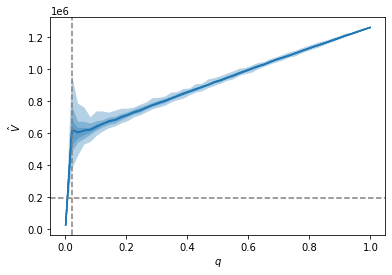

In [39]:
est_wor = np.zeros((n_experiments, n_steps))
flat_pop = np.repeat(np.arange(V), counts)
for j, q in enumerate(fractions):
    for i in range(n_experiments):
        _, sample = np.unique(np.random.choice(
            flat_pop, replace=False, size=int(q * N)), return_counts=True)
        est_wor[i, j] = chao1(sample)

fig, ax = plt.subplots()
ci_plot(fractions, est_wor, n=3, color="C0", ax=ax)
ax.set(ylabel="$\hat{V}$", xlabel="$q$")
ax.axvline(fractions[np.where(est_wor.mean(0) > V)[0]][0], color="grey", ls="--")
ax.axhline(V, color="grey", ls="--");

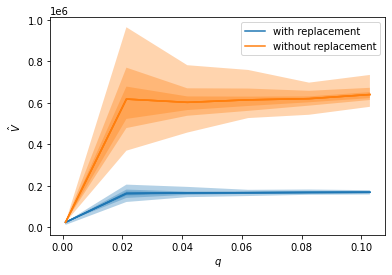

In [40]:
fig, ax = plt.subplots()

labels = "with replacement", "without replacement"
estimations = est_wr, est_wor

for i, (label, est) in enumerate(zip(labels, estimations)):
    ci_plot(fractions[:6], est[:, :6], n=3, color=f"C{i}", ax=ax, label=label)

ax.set(ylabel="$\hat{V}$", xlabel="$q$")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());

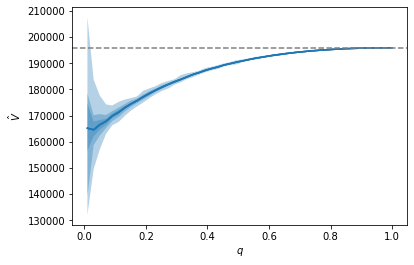

In [41]:
fractions = np.linspace(0.01, 0.999, n_steps)
estimations = np.zeros((n_experiments, n_steps))
flat_pop = np.repeat(np.arange(V), counts)
for j, q in enumerate(fractions):
    for i in range(n_experiments):
        _, sample = np.unique(np.random.choice(
            flat_pop, replace=False, size=int(q * N)), return_counts=True)
        estimations[i, j] = chao_wor(sample, q)

fig, ax = plt.subplots()
ci_plot(fractions, estimations, n=3, color="C0", ax=ax)
ax.set(ylabel="$\hat{V}$", xlabel="$q$")
ax.axhline(V, color="grey", ls="--");

In [44]:
n_steps, n_experiments = 20, 100
fractions = np.linspace(0.01, 0.999, n_steps)
q_hypotheses = np.linspace(0.01, 0.999, 20)
estimations = np.zeros((n_steps, 20))
flat_pop = np.repeat(np.arange(V), counts)
for k, h in enumerate(q_hypotheses):
    for j, q in enumerate(fractions):
        _ests = []
        for i in range(n_experiments):
            _, sample = np.unique(
                np.random.choice(flat_pop, replace=False, size=int(q * N)),
                return_counts=True)
            _ests.append(chao_wor(sample, h))
        estimations[j, k] = np.mean(_ests)

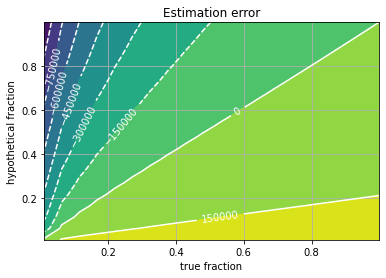

In [45]:
X, Y = np.meshgrid(fractions, q_hypotheses)
Z = V - estimations

fig, ax = plt.subplots()
ax.contourf(X, Y, Z)
CS = ax.contour(X, Y, Z, colors="w")
ax.clabel(CS, inline=True, fontsize=10)
ax.set(
    xlabel="true fraction",
    ylabel="hypothetical fraction",
    title="Estimation error")
ax.grid()